In [2]:
import numpy as np
import pylab
from scipy.optimize import fmin, fmin_ncg, fmin_cg
from scipy import linalg
from sys import stdout 
import kernels 

In [14]:
class GP:
    def __init__(self, X, Y, kernel=None, parameter_priors=None):
        self.N = Y.shape[0]
        self.setX(X)
        self.setY(Y)

        # kernel
        if kernel == None:
            self.kernel = kernels.RBF_full(-1, -np.ones(self.Xdim))
        else:
            self.kernel = kernel
            
        # parameter prior distribution
        if parameter_priors == None:
            self.parameter_prior_widths = np.ones(self.kernel.nparams + 1)
        else:
            assert parameter_priors.size == (self.kernel.nparams + 1)
            self.parameter_prior_widths = np.array(parameter_priors).flatten()
            
        # hyper param
        self.beta = 0.1
        self.update()
        self.n2ln2pi = 0.5 * self.Ydim * self.N * np.log(2 * np.pi)  # constant in the marginal. precompute for convenience.

    def setX(self, newX):
        self.X = newX.copy()
        N, self.Xdim = newX.shape
        assert N == self.N, "bad shape"
        # normalize...
        self.xmean = self.X.mean(0)
        self.xstd = self.X.std(0)
        self.X -= self.xmean
        self.X /= self.xstd

    def setY(self, newY):
        self.Y = newY.copy()
        N, self.Ydim = newY.shape
        assert N == self.N, "bad shape"
        # normalize...
        self.ymean = self.Y.mean(0)
        self.ystd = self.Y.std(0)
        self.Y -= self.ymean
        self.Y /= self.ystd

    def hyper_prior(self):
        """
        return the log of the current hyper paramters under their prior
        """
        return -0.5 * np.dot(self.parameter_prior_widths, np.square(self.get_params()))

    def hyper_prior_grad(self):
        """
        return the gradient of the (log of the) hyper prior for the current parameters
        """
        return -self.parameter_prior_widths * self.get_params()

    def get_params(self):
        """
        return the parameters of this GP: 
        that is the kernel parameters and the beta value
        """
        return np.hstack((self.kernel.get_params(), np.log(self.beta)))

    def set_params(self, params):
        """
        set the kernel parameters and the noise parameter beta
        """
        assert params.size == self.kernel.nparams + 1
        self.beta = np.exp(params[-1])
        self.kernel.set_params(params[:-1])

    def ll(self, params=None):
        """  
        A cost function to optimise for setting the kernel parameters. 
        Uses current parameter values if none are passed 
        """
        if not params == None:
            self.set_params(params)
        try:
            self.update()
        except:
            return np.inf
        return -self.marginal() - self.hyper_prior()

    def ll_grad(self, params=None):
        """ 
        the gradient of the ll function, for use with conjugate gradient optimisation. 
        uses current values of parameters if none are passed 
        """
        if not params == None:
            self.set_params(params)
        try:
            self.update()
        except:
            return np.ones(params.shape) * np.NaN
        self.update_grad()
        matrix_grads = [e for e in self.kernel.gradients(self.X)]
        matrix_grads.append(
            -np.eye(self.K.shape[0]) / self.beta
        )  # noise gradient matrix

        grads = [0.5 * np.trace(np.dot(self.alphalphK, e)) for e in matrix_grads]

        return -np.array(grads) - self.hyper_prior_grad()

    def find_kernel_params(self, iters=1000):
        """Optimise the marginal likelihood. work with the log of beta - fmin works better that way.  """
        # new_params = fmin(self.ll,np.hstack((self.kernel.get_params(), np.log(self.beta))),maxiter=iters)
        new_params = fmin_cg(
            self.ll,
            np.hstack((self.kernel.get_params(), np.log(self.beta))),
            fprime=self.ll_grad,
            maxiter=iters,
        )
        final_ll = self.ll(new_params)  # sets variables - required!

    def update(self):
        """do the Cholesky decomposition as required to make predictions and calculate the marginal likelihood"""
        self.K = self.kernel(self.X, self.X)
        self.K += np.eye(self.K.shape[0]) / self.beta
        self.L = np.linalg.cholesky(self.K)
        self.A = linalg.cho_solve((self.L, 1), self.Y)

    def update_grad(self):
        """do the matrix manipulation required in order to calculate gradients"""
        self.Kinv = np.linalg.solve(
            self.L.T, np.linalg.solve(self.L, np.eye(self.L.shape[0]))
        )
        self.alphalphK = np.dot(self.A, self.A.T) - self.Ydim * self.Kinv

    def marginal(self):
        """The Marginal Likelihood. Useful for optimising Kernel parameters"""
        return (
            -self.Ydim * np.sum(np.log(np.diag(self.L)))
            - 0.5 * np.trace(np.dot(self.Y.T, self.A))
            - self.n2ln2pi
        )

    def predict(self, x_star):
        """Make a prediction upon new data points"""
        x_star = (np.asarray(x_star) - self.xmean) / self.xstd

        # Kernel matrix k(X_*,X)
        k_x_star_x = self.kernel(x_star, self.X)
        k_x_star_x_star = self.kernel(x_star, x_star)

        # find the means and covs of the projection...
        # means = np.dot(np.dot(k_x_star_x, self.K_inv), self.Y)
        means = np.dot(k_x_star_x, self.A)
        means *= self.ystd
        means += self.ymean

        v = np.linalg.solve(self.L, k_x_star_x.T)
        # covs = np.diag( k_x_star_x_star - np.dot(np.dot(k_x_star_x,self.K_inv),k_x_star_x.T)).reshape(x_star.shape[0],1) + self.beta
        variances = (
            np.diag(k_x_star_x_star - np.dot(v.T, v)).reshape(x_star.shape[0], 1)
            + 1.0 / self.beta
        ) * self.ystd.reshape(1, self.Ydim)
        
        return means, variances



In [15]:
# generate data:
Ndata = 50
X = np.linspace(-3, 3, Ndata).reshape(Ndata, 1)
Y = np.sin(X) + np.random.standard_normal(X.shape) / 20

In [16]:
print("X :", X.shape)
print("Y :", Y.shape)

X : (50, 1)
Y : (50, 1)


In [17]:
# create GP object
myGP = GP(X, Y)  # ,kernels.linear(-1,-1))

In [18]:
# stuff for plotting
xx = np.linspace(-4, 4, 200).reshape(200, 1)
xx.shape

(200, 1)

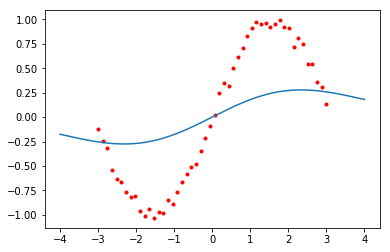

In [19]:
def plot():
    pylab.figure()
    
    # plot actual function
    pylab.plot(X, Y, "r.")
    
    # yy: mean, cc: var
    yy, cc = myGP.predict(xx)
    
    # plot predicted function
    pylab.plot(xx, yy, scaley=False)
    pylab.plot(xx, yy + 2 * np.sqrt(cc), "k--", scaley=False)
    pylab.plot(xx, yy - 2 * np.sqrt(cc), "k--", scaley=False)

plot()

In [26]:
myGP.kernel.get_params()

array([-1., -1.])

In [28]:
np.log(myGP.beta)

-2.3025850929940455

In [29]:
np.hstack((myGP.kernel.get_params(), np.log(myGP.beta)))

array([-1.        , -1.        , -2.30258509])

In [20]:

my1GP.find_kernel_params()
plot()

pylab.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()